In [1]:
from astropy.io import fits, ascii
from astropy.table import Table, Column, hstack
import pdb
import numpy as np
import rafias_lib as rl
import glob
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
fn1 = '/data1/tso_analysis/all_tso_cv3/raw_separated_MMM/NRCN821WLP8'
test = ['SUB', 'SUB640', 'FULL1', 'FULL2', 'FULL3', 'FULL4', 'FULL5']
a1 = ['-*_1_481_SE_*/*.slp.fits', '-*_1_481_SE_*/*.red.fits'] # 0 for slp, 1 for red
b4 = ['-*_1_489_SE_*/*.slp.fits', '-*_1_489_SE_*/*.red.fits']

In [3]:
cen_guess = [[(166,160), (162,156)], [(326,320), (319,316)], [(1405,1036), (828,821)], [(1405,1036), (828,821)], 
             [(1405,1036), (828,821)], [(1405,1036), (828,821)], [(1405,1036), (828,821)]]

In [9]:
def fname_generator(tests, center_guesses, div):
    """
    tests = list of test names as included in filenames
    div = the index of first test in tests that requires red files
    """
    
    fname = []
    cntrs = []
    for i, (t, c) in enumerate(zip(tests, center_guesses)):
        if i < div:                                          # Sub arrays, so slp files
            globals()['%s_a1_files' % t] = np.sort(glob.glob(fn1 + t + a1[0]))[2:]
            globals()['%s_b4_files' % t] = np.sort(glob.glob(fn1 + t + b4[0]))[2:]
            fname.append(globals()['%s_a1_files' % t])
            fname.append(globals()['%s_b4_files' % t])
            
            if t == 'SUB':
                fname[1] = SUB_b4_files[:-1]
            
            globals()['%s_a1_cntrs' % t] = rl.gen_center_g2d(c[0][0] ,c[0][1] ,5,500,2,2,0,fname[-2])
            globals()['%s_b4_cntrs' % t] = rl.gen_center_g2d(c[1][0] ,c[1][1] ,5,600,2,2,0,fname[-1])
            cntrs.append(globals()['%s_a1_cntrs' % t])
            cntrs.append(globals()['%s_b4_cntrs' % t])
            
            
        else:                                              # Full arrays, so red files
            globals()['%s_a1_files' % t] = np.sort(glob.glob(fn1 + t + a1[1]))[2:]
            globals()['%s_b4_files' % t] = np.sort(glob.glob(fn1 + t + b4[1]))[2:]
            fname.append(globals()['%s_a1_files' % t])
            fname.append(globals()['%s_b4_files' % t])
            
            globals()['%s_a1_cntrs' % t] = rl.gen_center_g2d(c[0][0] ,c[0][1] ,5,500,2,2,0,fname[-2], red = True)
            globals()['%s_b4_cntrs' % t] = rl.gen_center_g2d(c[1][0] ,c[1][1] ,5,600,2,2,0,fname[-1], red = True)
            cntrs.append(globals()['%s_a1_cntrs' % t])
            cntrs.append(globals()['%s_b4_cntrs' % t])
    
    return fname, cntrs

In [10]:
fnames, centers = fname_generator(test, cen_guess, 2)
len(fnames), len(centers) # 7 tests each with a1 & b4 sides

(14, 14)

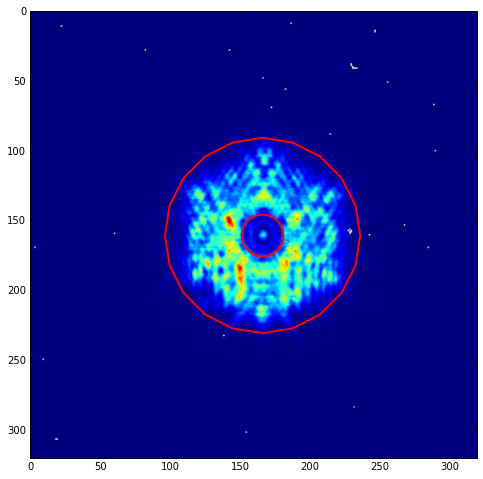

In [11]:
im, _, _, mask = rl.test_image(fnames[0][10])
ap = rl.photometry(im, [centers[0][1][10]], [centers[0][2][10]], mask, shape = 'CircAnn', r_in = 15, r_out = 70)[1]
plt.imshow(im)
ap.plot(color='r',linewidth=2)

In [12]:
def circular(fname1, fname2, cen1, cen2, r1 = 70, r_in1 = 72, r_out1 = 80, red1 = True):
    data1 = rl.time_series(cen1[1], cen1[2], fname1, r = r1, r_in = r_in1, r_out = r_out1, red = red1)
    data2 = rl.time_series(cen2[1], cen2[2], fname2, r = r1, r_in = r_in1, r_out = r_out1, red = red1)
    det1 = rl.linear_bestfit(data1['time'], data1['res_flux'], 0.00002, 1)
    det2 = rl.linear_bestfit(data2['time'], data2['res_flux'], 0.00002, 1)
    detav = (det1+det2)/2.
    stdev = np.std(detav/np.median(detav))*1e6
    return stdev

In [13]:
def annular(fname1, fname2, cen1, cen2, r_in1 = 72, r_out1 = 80, rs_in1 = 15, rs_out1 = 70, red1 = True):
    data1 = rl.time_series(cen1[1], cen1[2], fname1, r_in = r_in1, r_out = r_out1, rs_in = rs_in1, rs_out = rs_out1, 
                           red = red1, src_shape = 'CircAnn', bkg_shape = 'Circ')
    data2 = rl.time_series(cen2[1], cen2[2], fname2, r_in = r_in1, r_out = r_out1, rs_in = rs_in1, rs_out = rs_out1, 
                           red = red1, src_shape = 'CircAnn', bkg_shape = 'Circ')
    det1 = rl.linear_bestfit(data1['time'], data1['res_flux'], 0.00002, 1)
    det2 = rl.linear_bestfit(data2['time'], data2['res_flux'], 0.00002, 1)
    detav = (det1+det2)/2.
    stdev = np.std(detav/np.median(detav))*1e6
    return stdev

In [14]:
for i, (j, t) in enumerate(zip(range(0, 13, 2), test)):
    if i < 2 :
        globals()['Circ_%s' % t] = circular(fnames[j], fnames[j+1], centers[j], centers[j+1], red1 = False)
        globals()['Ann_%s' % t] = annular(fnames[j], fnames[j+1], centers[j], centers[j+1], red1 = False)
        print t, globals()['Circ_%s' % t], globals()['Ann_%s' % t]
        
    else:
        globals()['Circ_%s' % t] = circular(fnames[j], fnames[j+1], centers[j], centers[j+1])
        globals()['Ann_%s' % t] = annular(fnames[j], fnames[j+1], centers[j], centers[j+1])
    
        print t, globals()['Circ_%s' % t], globals()['Ann_%s' % t]

SUB 499.371763522 499.67375043
SUB640 1206.9736384 1201.51128413
FULL1 1294.07946194 1287.98888076
FULL2 1572.74699643 1565.04681454
FULL3 1030.34484944 1013.95817011
FULL4 1110.74502113 1106.39994356
FULL5 841.872163685 836.70576563


In [15]:
source = ['Circular', 'Annular']
result = Table(names=('Test name', source[0], source[1], 'Preferable Geometry'),
               dtype=('S16', 'f8', 'f8', 'S25'))
for t in test:
    a = globals()['Circ_%s' % t]
    b = globals()['Ann_%s' % t]
    if (a < b):
        best = source[0] + ' for ' + t
    else:
        best = source[1] + ' for ' + t
    result.add_row([t, a, b, best])
result

Test name,Circular,Annular,Preferable Geometry
str16,float64,float64,str25
SUB,499.371763522,499.67375043,Circular for SUB
SUB640,1206.9736384,1201.51128413,Annular for SUB640
FULL1,1294.07946194,1287.98888076,Annular for FULL1
FULL2,1572.74699643,1565.04681454,Annular for FULL2
FULL3,1030.34484944,1013.95817011,Annular for FULL3
FULL4,1110.74502113,1106.39994356,Annular for FULL4
FULL5,841.872163685,836.70576563,Annular for FULL5


In [17]:
ascii.write(result, 'source_geometry.tex', format = 'latex')